# Test different clustering methods to identify scenarios of high criticality
- PRIM
- K-means

In [1]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd

In [2]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [3]:
dbFile = 'lhc_samples/fleet_roadBlocked_scenarios.db'

In [4]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

comb_scenarios = {}
with ThreadPoolExecutor(max_workers=6) as executor:
    for result in executor.map(read_fleet_from_db, queries):
        comb_scenarios.update(result)

print(len(comb_scenarios))

Length of rows:  0
Length of rows:  34
Length of rows:  2000
Length of rows:  2000
Length of rows:  2000
6034


### Create Dataframes from the database read
- df_results: a dataframe of the results
- df: a dataframe of the inputs

In [5]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [6]:
experiments = df
### Create outcomes as an array of df_results
outcomes = list(df_results[0].values)

In [7]:
### print descriptive statistics of outcomes
print(df_results.describe())


                  0
count   6032.000000
mean   18935.958223
std     4913.071413
min     9600.000000
25%    13200.000000
50%    23400.000000
75%    23400.000000
max    30000.000000


In [10]:
from ema_workbench.analysis import prim

boxArr = []

x = experiments
### create a list y of boolean values based on outcome values > 23000
y = df_results[0].values > 20000
#y = outcomes["max_P"]

y

array([False,  True, False, ..., False,  True, False])

In [28]:
np_results = df_results[0].to_numpy()

In [29]:
np_results

array([16500., 23400., 13200., ..., 12900., 23400.,  9600.])

In [12]:
print(len(df_results[0]), len(x))

6034 6034


In [17]:
### print just the first 5 columns of x
print(x.iloc[:,0:5])

      24501202  105574370  10091169782  10091169911  10091170028
0            1          1            1            1            1
1            0          0            0            0            0
2            0          0            0            0            0
3            0          0            0            0            0
4            0          0            1            0            0
...        ...        ...          ...          ...          ...
6029         0          0            0            0            0
6030         0          0            0            0            0
6031         0          0            0            0            0
6032         0          0            0            1            0
6033         0          0            0            0            0

[6034 rows x 5 columns]


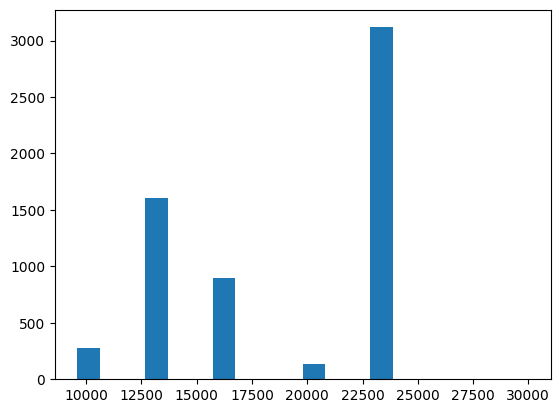

In [35]:
### plot df_results
import matplotlib.pyplot as plt

### plot histogram of df_results
plt.hist(df_results[0], bins=20)
plt.show()

In [36]:
import prim as p_rim

In [ ]:
prim_alg = p_rim.Prim(x, df_results[0], threshold=12000.0, threshold_type=">")


In [81]:
box = prim_alg.find_box()

In [82]:
box.limits

,min,max,qp values


In [76]:
### get the ids of the box.limits
primSegments = list(box.limits.index)
print(primSegments)


['91170028', '703766232', '10105537445', '999850568', '1173040622', '915734793', '116951485', '10711443269', '1172854308', '1155656405', '11116878000', '11172862678', '10105576311', '10105593939', '708958458', '105576314']


In [96]:
print(len(df_results), len(df))

### create a new dataframe from df that only includes the rows where the results are greater than 16400
dfMAX = df[df_results[0] > 23000]
#dfMAX = df[df_results[0] > 4.3]

### create a new dataframe from df_results that only includes the rows where the results are greater than 16400
df_resultsMAX = df_results[df_results[0] > 23000]
#df_resultsMAX = df_results[df_results[0] > 4.3]

print(len(dfMAX), len(df_resultsMAX))

6034 6034
3121 3121


In [97]:
### cluster the results
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=21).fit(dfMAX)

### print the count of each cluster
print(pd.Series(kmeans.labels_).value_counts())


2    1443
3    1226
1     411
0      41
Name: count, dtype: int64


In [98]:
### get the index's of results for each cluster
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

idx0 = []
idx1 = []
idx2 = []
idx3 = []

for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] == 0:
        cluster0.append(df_resultsMAX[0].iloc[i])
        idx0.append(i)
    elif kmeans.labels_[i] == 1:
        cluster1.append(df_resultsMAX[0].iloc[i])
        idx1.append(i)
    elif kmeans.labels_[i] == 2:
        cluster2.append(df_resultsMAX[0].iloc[i])
        idx2.append(i)
    elif kmeans.labels_[i] == 3:
        cluster3.append(df_resultsMAX[0].iloc[i])
        idx3.append(i)

len(cluster0)

41

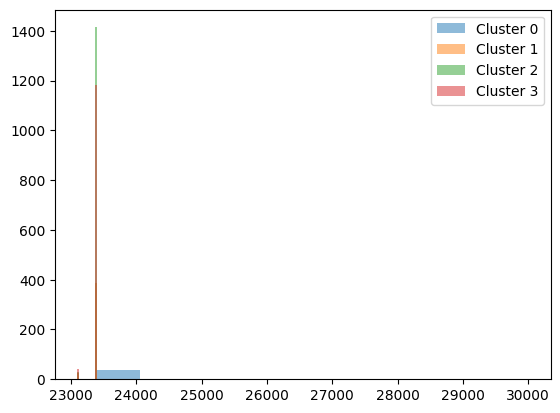

In [99]:
### plot a histogram all the clusters
plt.hist(cluster0, bins=10, alpha=0.5, label='Cluster 0')
plt.hist(cluster1, bins=10, alpha=0.5, label='Cluster 1')
plt.hist(cluster2, bins=10, alpha=0.5, label='Cluster 2')
plt.hist(cluster3, bins=10, alpha=0.5, label='Cluster 3')
plt.legend(loc='upper right')
plt.show()

In [100]:
### print colum names of df.iloc[idx0] that have values greater than 0
print(len(df.iloc[idx0].columns[(df.iloc[idx0] > 0).any()]))
print(len(df.iloc[idx1].columns[(df.iloc[idx1] > 0).any()]))
print(len(df.iloc[idx2].columns[(df.iloc[idx2] > 0).any()]))
print(len(df.iloc[idx3].columns[(df.iloc[idx3] > 0).any()]))



507
579
579
579


In [130]:
### for each df.iloc[idx0] print the sum of all columns sorted from highest to lowest
print(df.iloc[idx0].sum().sort_values(ascending=False))

### get the top 10 columns of df.iloc[idx0] that have the highest sum
maxSegs0 = df.iloc[idx0].sum().sort_values(ascending=False).head(200)
maxSegs1 = df.iloc[idx1].sum().sort_values(ascending=False).head(200)
maxSegs2 = df.iloc[idx2].sum().sort_values(ascending=False).head(200)
maxSegs3 = df.iloc[idx3].sum().sort_values(ascending=False).head(200)


116967913      7
91169782       7
949300629      7
10915734790    7
711115701      6
              ..
10091170132    0
711379673      0
1156005087     0
711251380      0
105537445      0
Length: 579, dtype: int64


In [131]:
overlaps = []
### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx1]
overlap = maxSegs0.index.intersection(maxSegs1.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx2]
overlap = maxSegs0.index.intersection(maxSegs2.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx3]
overlap = maxSegs0.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx1] and df.iloc[idx2]
overlap = maxSegs1.index.intersection(maxSegs2.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx1] and df.iloc[idx3]
overlap = maxSegs1.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx2] and df.iloc[idx3]
overlap = maxSegs2.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)


Index(['116967913', '10915734790', '10711209710', '710783587', '10915734793',
       '10946271023', '91435359', '10709015679', '10711121748', '10949397063',
       '1175069740', '91170205', '10708958458', '949279124', '105593873',
       '11173060575', '704124376', '105540011', '10710782580', '10703777459',
       '10127825675', '105574067', '10105574368', '703777459', '10703777750',
       '105593568', '949290447', '1156080182', '1116878000', '949397070',
       '10708548339', '1173048757', '116964285', '105539210', '10105538098',
       '10105593499', '1156090945', '10105537958', '24501202', '10105537672',
       '105539772', '105538755', '11173040622', '11173048767', '10704061070',
       '703766145', '91169778', '10711379673', '91170619', '10105540066',
       '937800492', '10105537818', '105593939', '708957454', '116970510',
       '11172978481', '10091167864', '105574369', '11155878755', '10116952815',
       '709015681', '1156083863', '105593941', '10710782582', '711440306',
   

In [138]:
for o in overlaps:
    for i in o:
        if i in primSegments:
            print(i)

999850568
10105576311
116951485
1155656405
10711443269


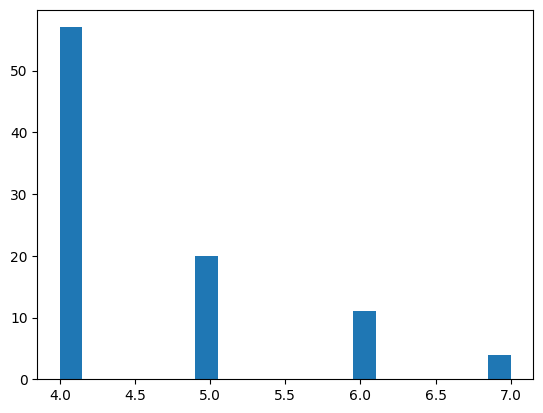